In [1]:
import sys,os,re
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sb

from theory_code.distance_theory import TheoryCalcs
from mock_data.mock_data_code    import MockCalcs

from itertools import product
from copy      import deepcopy
from time      import time

from scipy.interpolate import interp1d
from scipy.integrate   import trapz

import warnings
warnings.filterwarnings('ignore')

import matplotlib
from matplotlib import rc
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm

rc('text', usetex=True)
rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 18})


sidelegend = {'bbox_to_anchor': (1.04,0.5), 
              'loc': "center left",
              'frameon': False}

# Settings

## Theory

In [2]:
fiducial = {'H0': 68.53,
            'omegam': 0.2948,
            'ombh2': 0.02218,
            'omk': 0.,
            'epsilon0_EM': 0.,
            'epsilon0_GW': 0.,
            'mnu': 0.06,
            'nnu': 3.,
            'MB': -19.2435}

settings = {'zmin': 0.001,
            'zmax': 5.,
            'Nz': 1000,
            'zdrag': 1060,
            'DDR_model': 'constant'}


## Observables

In [21]:
obs_settings = {'BAO' : {'distribution': 'binned',
                         'error_type' : 0.05,
                         'correlation': False,
                         'BAO_file_path' : './mock_data/BAOmock',
                         'zmin': 0.65,
                         'zmax': 1.85,
                         'N_bin': 14,
                         'spread_data': True},
                'SN' : {'distribution': 'Euclid',
                        'error_type' : 'LSST-like',
                        'correlation': False,
                        'SN_file_path' : './mock_data/SNmock',
                        'zmin': 0.1,
                        'zmax': 1.0,
                        'N_SN': 8800,
                        'spread_data': True},
               'GW' : {'distribution': 'BNS',
                       'error_type' : 0.1,
                       'GW_file_path' : './mock_data/GWmock',
                       'correlation': False,
                       'zmin': 0.001,
                       'zmax': 5.0,
                       'N_gw': 1000,
                       'spread_data': True}}

# Creating mock data

## Getting fiducial theory

In [22]:
fiducial_theory = TheoryCalcs(settings,fiducial)
zplot = np.linspace(0.01,3,100)

## Initializing mock class

In [23]:
mock = MockCalcs(settings, obs_settings, fiducial, fiducial_theory)

## BAO data

**Minor problem here: the format with which BAO_data is obtained is different from the one used in the likelihood. we should make those match**

**Also, DV should probably be on different redshifts than DH and DM**

In [24]:
if 'BAO' in obs_settings:
    BAO_data = mock.data_BAO

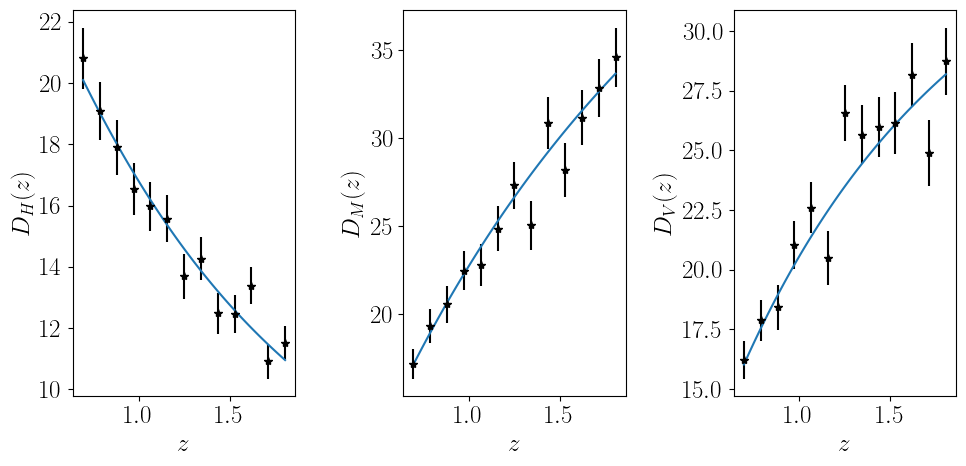

In [25]:
if 'BAO' in obs_settings:
    
    zplot = np.linspace(min(BAO_data['z']),max(BAO_data['z']),100)
    
    fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True,subplot_kw=dict(frameon=True),figsize=(10,5))
    axes[0].errorbar(BAO_data['z'],BAO_data['DH'],yerr=BAO_data['err_DH'],ls='',marker='*',color='black')
    axes[0].plot(zplot,fiducial_theory.DH(zplot))
    axes[0].set_xlabel(r'$z$')
    axes[0].set_ylabel(r'$D_H(z)$')
    
    axes[1].errorbar(BAO_data['z'],BAO_data['DM'],yerr=BAO_data['err_DM'],ls='',marker='*',color='black')
    axes[1].plot(zplot,fiducial_theory.DM(zplot))
    axes[1].set_xlabel(r'$z$')
    axes[1].set_ylabel(r'$D_M(z)$')
    
    axes[2].errorbar(BAO_data['z'],BAO_data['DV'],yerr=BAO_data['err_DV'],ls='',marker='*',color='black')
    axes[2].plot(zplot,fiducial_theory.DV(zplot))
    axes[2].set_xlabel(r'$z$')
    axes[2].set_ylabel(r'$D_V(z)$')
    
    plt.tight_layout();

## SN data

In [26]:
if 'SN' in obs_settings:
    SN_data = mock.data_SN

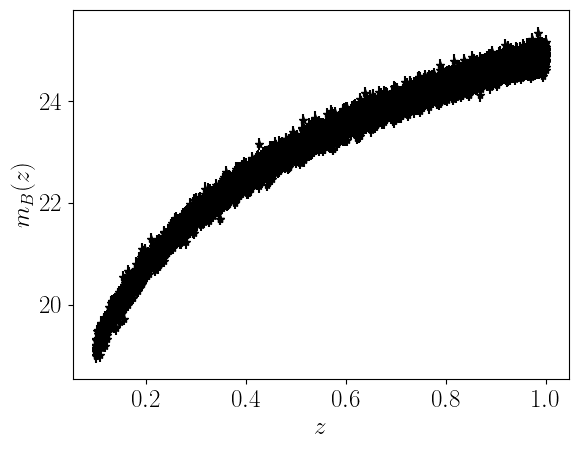

In [27]:
if 'SN' in obs_settings:
    
    zplot = np.linspace(min(SN_data['z']),max(SN_data['z']),100)
    
    plt.figure()
    plt.plot(zplot,fiducial_theory.mB(zplot))
    plt.errorbar(SN_data['z'],SN_data['mB'],yerr=SN_data['err_mB'],ls='',marker='*',color='black')
    plt.xlabel(r'$z$')
    plt.ylabel(r'$m_B(z)$');

## Standard Sirens data

In [28]:
if 'GW' in obs_settings:    
    GW_data = mock.data_GW

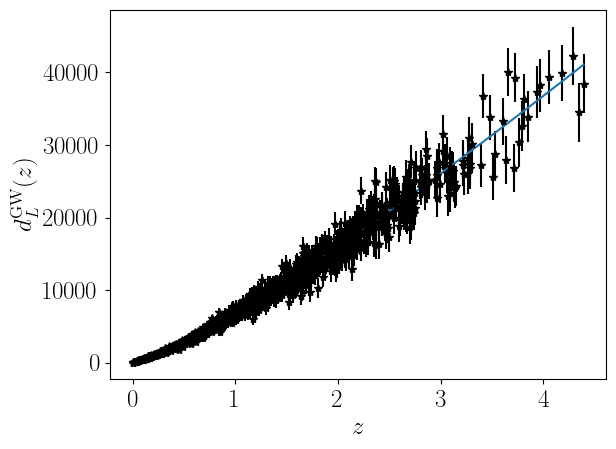

In [29]:
if 'GW' in obs_settings: 
    zplot = np.linspace(min(GW_data['z']),max(GW_data['z']),100)
    
    plt.figure()
    plt.errorbar(GW_data['z'],GW_data['dL'],yerr=GW_data['err_dL'],ls='',marker='*',color='black')
    plt.plot(zplot,fiducial_theory.DL_GW(zplot))
    plt.xlabel(r'$z$')
    plt.ylabel(r'$d_L^{\rm GW}(z)$');